<a href="https://colab.research.google.com/github/Lucas-doc26/Metric-Learning/blob/main/Metric_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Metric Learning

Os arquivos para teste podem ser baixados em: https://drive.google.com/drive/folders/16ZiGSYyLaxUJKOXjO7MIzkjfv6g-uJCZ?usp=sharing

Descompactando o dataset

In [ ]:
import zipfile

with zipfile.ZipFile('/content/post-processed.zip', 'r') as zipf:
    zipf.extractall('Dataset')

Importações princiapis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from collections import defaultdict
import os

## Dataset - Geração dos Triplets

Mapeando as fotos de cada uma das pessoas

In [ ]:
data_dir = '/content/Dataset/post-processed'

def build_person_to_images_map(root_dir):
    imgs = 0
    person_to_images = defaultdict(list)
    for person_name in os.listdir(root_dir):
        person_path = os.path.join(root_dir, person_name)
        if os.path.isdir(person_path):
            for img_name in os.listdir(person_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    person_to_images[person_name].append(os.path.join(person_path, img_name))
                    imgs += 1

    # Filtrar pessoas com menos de 2 imagens, pois não podem formar um (Anchor, Positive)
    person_to_images = {k: v for k, v in person_to_images.items() if len(v) >= 2}

    return person_to_images, imgs

person_to_images, num_imgs = build_person_to_images_map(data_dir)
all_persons_name = list(person_to_images.keys())
num_persons = len(all_persons_name)
print(f"O número total de pessoas para triplets: {num_persons}, total de imagens: {num_imgs}")

O número total de pessoas para triplets: 2984, total de imagens: 12000


Pré-processamento das imagens

In [ ]:
def preprocess(image_path, img_height=224, img_width=224):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

Gerar os triplets


In [ ]:
def triplet_generator(person_to_images, preprocess):
    """
    Retorna o triplet gerado. Composto por:
    * Anchor - Pessoa alvo
    * Positive - Outra foto da pessoa alvo
    * Negative - Foto de outra pessoa
    * 0 - Label (não usado)
    """
    persons = list(person_to_images.keys())

    while True:
        anchor_person = random.choice(persons)
        anchor_imgs = person_to_images[anchor_person]

        #verificação extra
        if len(anchor_imgs) < 2:
            continue

        #escolhe duas imagens diferentes da mesma pessoa
        anchor_path, positive_path = random.sample(anchor_imgs, 2)

        negative_person = random.choice([p for p in persons if p != anchor_person])
        negative_imgs = person_to_images[negative_person]
        negative_path = random.choice(negative_imgs)

        anchor = preprocess(anchor_path)
        positive = preprocess(positive_path)
        negative = preprocess(negative_path)

        # Converte para tensores do TF
        anchor = tf.convert_to_tensor(anchor, dtype=tf.float32)
        positive = tf.convert_to_tensor(positive, dtype=tf.float32)
        negative = tf.convert_to_tensor(negative, dtype=tf.float32)

        yield (anchor, positive, negative), 0  # label dummy


Geração dos datasets

In [ ]:
# especifica o formato de saída do gerador
output_signature = (
    (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),  # anchor
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),  # positive
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),  # negative
    ),
    tf.TensorSpec(shape=(), dtype=tf.int32)  # label
)

# embaralha e faz o split dos dados
all_persons = list(person_to_images.keys())
random.shuffle(all_persons)

train_split = int(0.9 * len(all_persons))

train_persons = all_persons[:train_split]
val_persons = all_persons[train_split:]

# filtra os dicionários para treino e validação
train_dict = {p: person_to_images[p] for p in train_persons}
val_dict = {p: person_to_images[p] for p in val_persons}

batch_size = 32


# cria os datasets de treino e validação
train_dataset = tf.data.Dataset.from_generator(
    lambda: triplet_generator(train_dict, preprocess),
    output_signature=output_signature
).batch(batch_size).prefetch(tf.data.AUTOTUNE) #-> prefetch para performance

val_dataset = tf.data.Dataset.from_generator(
    lambda: triplet_generator(val_dict, preprocess),
    output_signature=output_signature
).batch(batch_size).prefetch(tf.data.AUTOTUNE)


## Modelo

Função de perda para os triplets

In [ ]:
def triplet_loss(margin=0.3):
    def loss(y_true, y_pred):
        anchor, positive, negative = tf.split(y_pred, num_or_size_splits=3, axis=1)

        # distância euclidiana
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)

        # triplet Loss
        basic_loss = pos_dist - neg_dist + margin
        loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
        return loss
    return loss


Modelo base: VGG16

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16

def create_embedding_model_vgg16(input_shape=(224, 224, 3), embedding_dim=224, dropout_rate=0.3):
    # VGG16 pré-treinado sem as camadas densas no topo
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # congela as camadas
    for layer in base_model.layers:
        layer.trainable = False

    inputs = layers.Input(shape=input_shape)

    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(embedding_dim)(x)

    # normaliza o vetor de embedding
    outputs = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)

    model = Model(inputs, outputs, name='EmbeddingModel_VGG16')
    return model

Criação do modelo

In [ ]:
input_shape = (224, 224, 3)
embedding_dim = 224

embedding_model = create_embedding_model_vgg16(input_shape, embedding_dim)

# input das 3 imagens
anchor_input = layers.Input(name="anchor", shape=input_shape)
positive_input = layers.Input(name="positive", shape=input_shape)
negative_input = layers.Input(name="negative", shape=input_shape)

# passa as 3 imagens pelo mesmo modelo de embedding
anchor_embedding = embedding_model(anchor_input)
positive_embedding = embedding_model(positive_input)
negative_embedding = embedding_model(negative_input)

# concatena embeddings
merged_output = layers.concatenate([anchor_embedding, positive_embedding, negative_embedding], axis=1)

model = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=merged_output
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer='adam', loss=triplet_loss(margin=0.3))

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingModel_VGG… │ (None, 224)       │ 14,829,600 │ anchor[0][0],     │
│ (Functional)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 672)       │          0 │ EmbeddingModel_V… │
│ (Concatenate)       │                   │            │ EmbeddingModel_V… │
│                     │                   │            │ EmbeddingModel_V… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,829,600 (56.57 MB)

 Trainable params: 114,912 (448.88 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Treinamento do modelo

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

steps_per_epoch_train = len(train_dict) // batch_size
steps_per_epoch_val = len(val_dict) // batch_size


checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=steps_per_epoch_val,
    callbacks=[checkpoint]
)

Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.0000e+00 - loss: 0.2467
Epoch 1: loss improved from inf to 0.23886, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 84s 954ms/step - accuracy: 0.0000e+00 - loss: 0.2466 - val_accuracy: 0.0000e+00 - val_loss: 0.2315
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.0000e+00 - loss: 0.2350
Epoch 2: loss improved from 0.23886 to 0.22537, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 77s 935ms/step - accuracy: 0.0000e+00 - loss: 0.2349 - val_accuracy: 0.0000e+00 - val_loss: 0.2149
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.0000e+00 - loss: 0.2211
Epoch 3: loss improved from 0.22537 to 0.21879, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 982ms/step - accuracy: 0.0000e+00 - loss: 0.2210 - val_accuracy: 0.0000e+00 - val_loss: 0.1879
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.0000e+00 - loss: 0.2202
Epoch 4: loss did not improve from 0.21879
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 993ms/step - accuracy: 0.0000e+00 - loss: 0.2202 - val_accuracy: 0.0000e+00 - val_loss: 0.2063
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.0000e+00 - loss: 0.2298
Epoch 5: loss improved from 0.21879 to 0.21759, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 74s 893ms/step - accuracy: 0.0000e+00 - loss: 0.2296 - val_accuracy: 0.0000e+00 - val_loss: 0.1935


<Axes: >

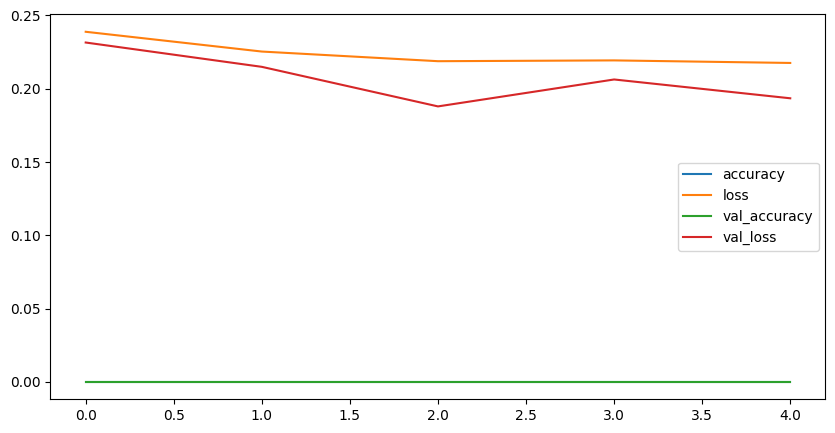

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10, 5))

## Criação do "banco de dados"

In [ ]:
database = {}

for person, images_paths in person_to_images.items():
    embeddings = []

    for i in range(0, len(images_paths), batch_size):
        batch_paths = images_paths[i:i + batch_size]

        batch_images = [preprocess(p) for p in batch_paths]
        batch_images = np.array(batch_images)

        batch_embeddings = embedding_model.predict(batch_images, verbose=0)

        # Guarda tuplas (embedding, caminho da imagem)
        for emb, path in zip(batch_embeddings, batch_paths):
            embeddings.append({"embedding": emb, "image_path": path})

    database[person] = embeddings


Normalização das imagens no banco de dados

In [ ]:
def normalize(vec):
    return vec / (np.linalg.norm(vec) + 1e-10)

# Normaliza todo o banco
for person, embeddings_list in database.items():
    for item in embeddings_list:
        item['embedding'] = normalize(item['embedding'])

## Distância euclidiana

In [ ]:
from numpy.linalg import norm
import matplotlib.image as mpimg

def find_closest_person_euclidean(embedding, database):
    min_dist = float('inf')
    identity = None
    matched_image = None

    for person, embeddings_list in database.items():
        for item in embeddings_list:
            db_embedding = item['embedding']
            dist = norm(embedding - db_embedding)

            if dist < min_dist:
                min_dist = dist
                identity = person
                matched_image = item['image_path']

    return identity, min_dist, matched_image


def show_comparison(input_img_path, matched_img_path, score):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    img_input = mpimg.imread(input_img_path)
    img_match = mpimg.imread(matched_img_path)

    axs[0].imshow(img_input)
    axs[0].set_title("Imagem de Entrada")
    axs[0].axis('off')

    axs[1].imshow(img_match)
    axs[1].set_title(f"Correspondente no banco de dados \n Distância euclidiana: {score:.4f}")
    axs[1].axis('off')

    plt.show()



## Teste

In [ ]:
new_img_path = '/content/elon_no_db.jpeg'
new_img = preprocess(new_img_path)
new_img = np.expand_dims(new_img, axis=0) # adiciona dimensão de batch
new_embedding = embedding_model.predict(new_img)[0]

database['Elon'] = [{"embedding": new_embedding, "image_path": new_img_path}]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [ ]:
img_inference_path = '/content/elon.jpg'
img_inference = preprocess(img_inference_path)
img_inference = np.expand_dims(img_inference, axis=0)
embedding_inference = embedding_model.predict(img_inference)[0]
embedding_inference = normalize(embedding_inference)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Pessoa mais próxima: Elon
Imagem associada: /content/elon_no_db.jpeg


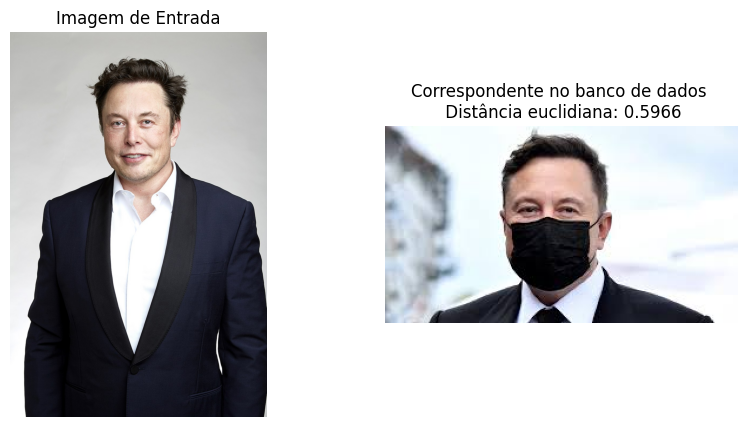

In [ ]:
person, score, matched_img = find_closest_person_euclidean(embedding_inference, database)

print(f'Pessoa mais próxima: {person}')
print(f'Imagem associada: {matched_img}')

show_comparison(img_inference_path, matched_img, score)